In [65]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from collections import OrderedDict
import csv
import pandas as pd
import xml.etree.ElementTree as ET

audioInput = 0
bpm = 0
fs = 0
path_to_data_set = '../mp3/'
path = 'aphex_twin_ageispolis_30_sec.mp3'

#### Get audio vector and inital tempo estimation

In [66]:
def get_audio_and_tempo(path):    
    loader = estd.AudioLoader(filename=path)
    downmixer = estd.MonoMixer()
    audioInput = loader()
    tempAudioInput, fs, num_channels, md5, bit_rate, codec = loader()
    audioInput = downmixer(tempAudioInput, num_channels)
    tempo_estimation_algo = estd.PercivalBpmEstimator(maxBPM=250, minBPM=40, sampleRate=int(fs))
    bpm = tempo_estimation_algo(audioInput)
    print(bpm, 'bpm, ', fs, 'Hz')
    return audioInput, bpm, fs

#### Compute spectrogram and 2-band energy

In [67]:
def compute_spectrogram(path):
    ## var init
    beat_duration = (60/bpm)*fs  # in samples
    frame_size = int(round(beat_duration/32))
    hop_size = round(frame_size/2)
    fft_size = int(np.power(2, np.ceil(np.log2(frame_size))))
    padding_size = fft_size - frame_size
    band1 = (1, 3000)
    if fs == 16000.0: # assuming fs is either going to be 16000 or 44100 and not any other value.
        band2 = (5443, 7619)
    elif fs == 44100.0:
        band2 = (15000, 21000)
    energy_threshold = 500.0    # the 1st energy_ratio value above this will be understood as first note in audio file

    ## get necessary Essentia algorithms
    window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann', zeroPadding = padding_size)
    fft_algo = estd.FFT(size = fft_size)
    energy1_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band1[0], stopCutoffFrequency=band1[1])
    energy2_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band2[0], stopCutoffFrequency=band2[1])


    spectrogram = []
    db_spectrogram = []
    print('Frame Size:', frame_size)
    print('FFT Size:', fft_size)
    print('Padding length:', padding_size)

    first_note_flag = None
    for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
        ## spectrogram
        windowed_frame = window_algo(frame)
        mX = abs(fft_algo(windowed_frame))
        mX[mX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
        dbX = 20 * np.log10(mX)
        spectrogram.append(np.array(mX))
        db_spectrogram.append(np.array(dbX))

        # energies and first note location
        energy1 = energy1_algo(mX)
        energy2 = energy2_algo(mX)
        energy_ratio = energy1/energy2
        if (first_note_flag == None) and (energy_ratio > energy_threshold):
            first_note_flag = index
            print("Found first note for frame with E1=", energy1, ", E2=", energy2, ", and E1/E2=", energy_ratio)
    spectrogram = np.array(spectrogram)
    db_spectrogram = np.array(db_spectrogram)
    print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)
    return spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag

#### Plot Spectrogram (for visual feedback only)

101.33271789550781 bpm,  44100.0 Hz
Frame Size: 816
FFT Size: 1024
Padding length: 208
Found first note for frame with E1= 0.0006667437264695764 , E2= 3.7690792709099696e-08 , and E1/E2= 17689.8302886743
Spectrogram done. Size is (axis1, axis2): (3264, 513)


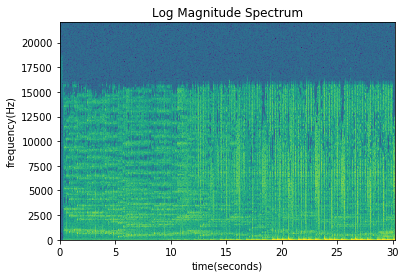

In [68]:
full_path = path_to_data_set + path
audioInput, bpm, fs = get_audio_and_tempo(full_path)
spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(full_path)


timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [69]:
## time(sec) of found first note
print('First note found at time:', first_note_flag*hop_size/fs, 'seconds')

First note found at time: 0.3053061224489796 seconds


Frame Size: 816
FFT Size: 1024
Padding length: 208
Found first note for frame with E1= 0.0006667437264695764 , E2= 3.7690792709099696e-08 , and E1/E2= 17689.8302886743
Spectrogram done. Size is (axis1, axis2): (3264, 513)


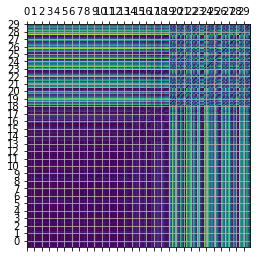

In [70]:
spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(path)
ref_ASM = squareform(pdist(spectrogram[first_note_flag:]))

labels = list(range(int(len(audioInput)/fs)))
plt.matshow(ref_ASM[::-1])
stride = list(np.multiply(fs/hop_size, labels))
plt.xticks(stride, labels)
plt.yticks(stride, labels[::-1])
plt.grid(True)

In [71]:
bar_candidates = np.multiply(64, list(range(2, 13)))

In [72]:
def segment_diagonal(diagonal, bar_length):
    return [diagonal[i:i+bar_length] for i in range(0, len(diagonal), bar_length)]

In [73]:
def compute_similarity():
    ref_ASM = squareform(pdist(spectrogram[first_note_flag:]))
    diagonals = {}
    SCS = {}
    SIS = {}
    SM = {}
    for bar in bar_candidates:
        diagonals[bar] = {}
        numb_diagonals = int(ref_ASM.shape[0]/bar)
        for i in range(1, numb_diagonals+1):
            diagonals[bar][i] = list(np.diagonal(ref_ASM, bar*i))
            diagonals[bar][i] = segment_diagonal(diagonals[bar][i], bar)
        SCS[bar] = {}
        SIS[bar] = {}
        for diagonal in range(1, numb_diagonals+1):
            SCS[bar][diagonal] = []
            SIS[bar][diagonal] = []
            for segment in diagonals[bar][diagonal]:
                if len(segment) == bar:
                    SCS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
                elif len(segment) != bar:
                    SIS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
        SM[bar] = None
        scsi = 0
        sisi = 0
        sc = 0
        si = 0
        if len(diagonals[bar]) is 0:
            r = 0
        else: 
            r = len(diagonals[bar][1][-1])
        for diagonal in range(1, numb_diagonals+1):
            scsi += sum(SCS[bar][diagonal][:])
            sisi += SIS[bar][diagonal][0]
            sc += len(SCS[bar][diagonal][:])
            si += len(SIS[bar][diagonal][:])
        SM[bar] = (bar*scsi + r*sisi)/(bar*sc + r*si)
    return SM

In [74]:
path_to_csv = '../annotations_final.csv'
path_to_xml = '../mp3_echonest_xml'
pd_annotations = pd.read_csv(path_to_csv, '\t')

def getTrackCollection(tag='rock', num=1, minConfidence=0.8):
    collection = {}
    for i in range(pd_annotations.shape[1]):
        if pd_annotations[tag][i] == 1:
            xml_track = ET.parse(path_to_xml + '/' + pd_annotations['mp3_path'][i] + '.xml').getroot()
            for child in xml_track:
                if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                    if child.attrib['timeSignature'] not in collection:
                        collection[child.attrib['timeSignature']] = []
                    if len(collection[child.attrib['timeSignature']]) < num:
                        if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                            collection[child.attrib['timeSignature']].append({'path': pd_annotations['mp3_path'][i],
                                                                          'timeSignatureConfidence': child.attrib['timeSignatureConfidence'],
                                                                          'tempo':child.attrib['tempo']})    
    return collection

4
../mp3/c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.09705301374197006 , E2= 1.695222636044491e-05 , and E1/E2= 5725.089535639194
Spectrogram done. Size is (axis1, axis2): (2560, 257)
11.0
is estimation equal to truth? False


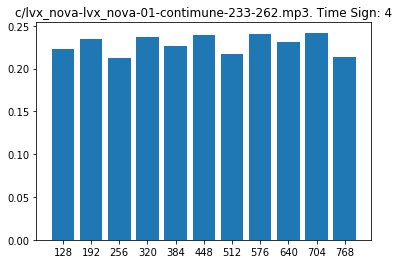

../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-30-59.mp3
98.03921508789062 bpm,  16000.0 Hz
Frame Size: 306
FFT Size: 512
Padding length: 206
Found first note for frame with E1= 0.13540951907634735 , E2= 1.831292138376739e-05 , and E1/E2= 7394.206322338861
Spectrogram done. Size is (axis1, axis2): (3045, 257)
12.0
is estimation equal to truth? False


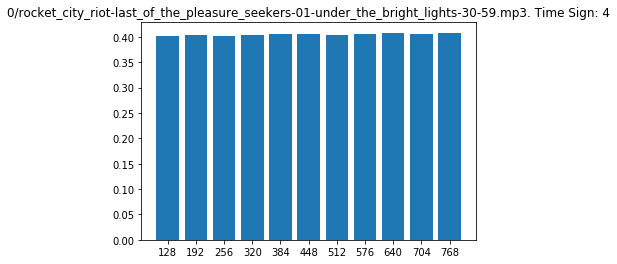

../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-146-175.mp3
94.93670654296875 bpm,  16000.0 Hz
Frame Size: 316
FFT Size: 512
Padding length: 196
Found first note for frame with E1= 0.2229491025209427 , E2= 0.0003804757434409112 , and E1/E2= 585.974549927037
Spectrogram done. Size is (axis1, axis2): (2949, 257)
10.0
is estimation equal to truth? False


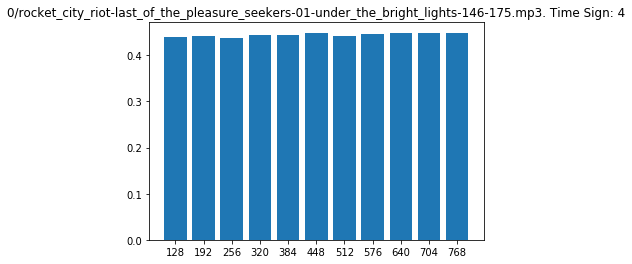

0
7
../mp3/c/mountain_mirrors-lunar_ecstasy-01-a_short_burst_of_clarity-146-175.mp3
85.2272720336914 bpm,  16000.0 Hz
Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 1.7599653574507101e-06 , E2= 1.984805375609966e-10 , and E1/E2= 8867.193625520293
Spectrogram done. Size is (axis1, axis2): (2647, 257)
11.0
is estimation equal to truth? False


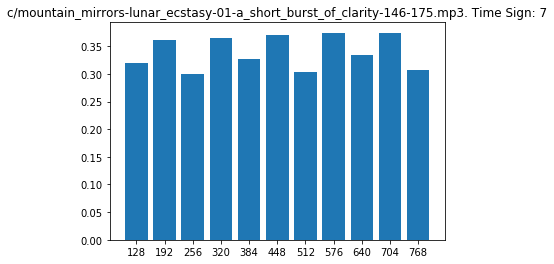

4
../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.0006346059963107109 , E2= 1.0131707313121296e-06 , and E1/E2= 626.356424142701
Spectrogram done. Size is (axis1, axis2): (3949, 129)
12.0
is estimation equal to truth? False


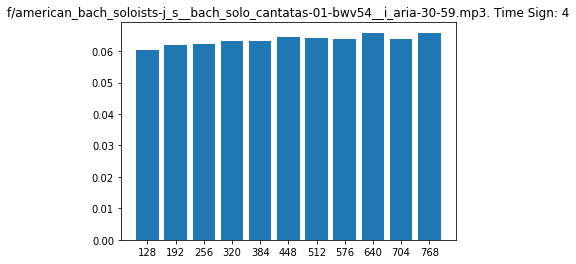

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 2.1485303136614675e-07 , E2= 1.8100462795267447e-10 , and E1/E2= 1187.0029722241263
Spectrogram done. Size is (axis1, axis2): (3949, 129)
11.0
is estimation equal to truth? False


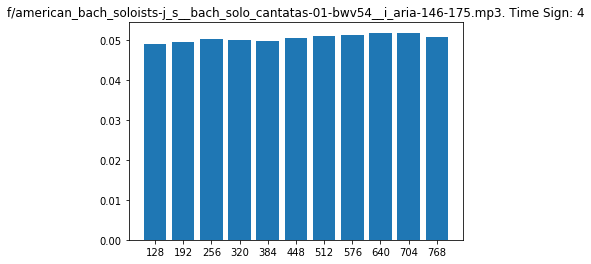

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-262-291.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.006790936924517155 , E2= 5.091570074000629e-06 , and E1/E2= 1333.760868615773
Spectrogram done. Size is (axis1, axis2): (3949, 129)
11.0
is estimation equal to truth? False


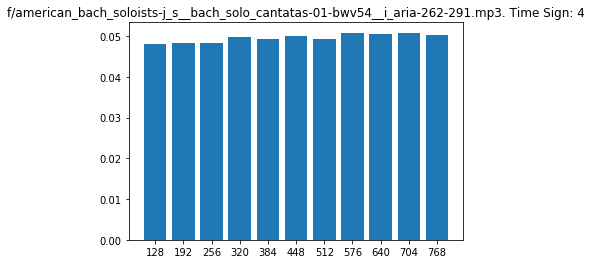

3
../mp3/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 9.240314824410234e-08 , E2= 1.4515863511199711e-10 , and E1/E2= 636.5666649649104
Spectrogram done. Size is (axis1, axis2): (3851, 129)
11.0
is estimation equal to truth? False


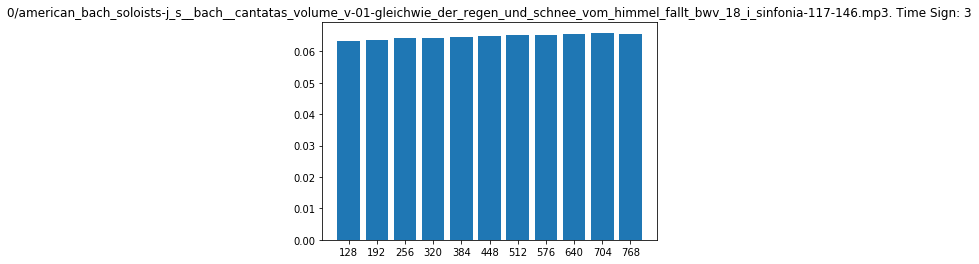

../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-407-436.mp3
65.78947448730469 bpm,  16000.0 Hz
Frame Size: 456
FFT Size: 512
Padding length: 56
Found first note for frame with E1= 1.3292846290369198e-07 , E2= 1.5740186931623157e-10 , and E1/E2= 844.516418268383
Spectrogram done. Size is (axis1, axis2): (2043, 257)
12.0
is estimation equal to truth? False


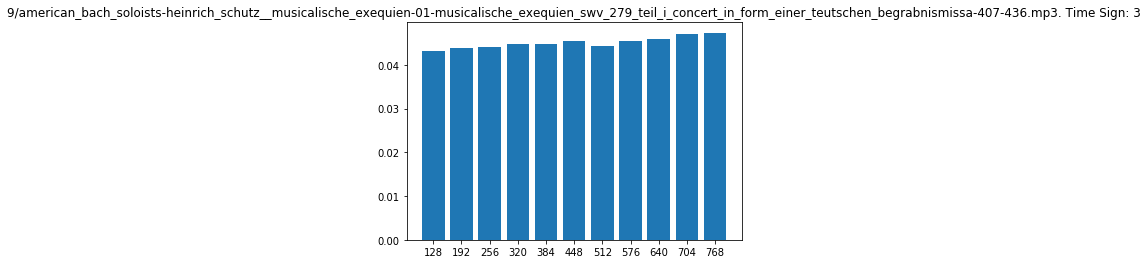

../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-1248-1277.mp3
122.95082092285156 bpm,  16000.0 Hz
Frame Size: 244
FFT Size: 256
Padding length: 12
Found first note for frame with E1= 1.230417296937958e-07 , E2= 1.1093490709379594e-10 , and E1/E2= 1109.1344727928015
Spectrogram done. Size is (axis1, axis2): (3819, 129)
12.0
is estimation equal to truth? False


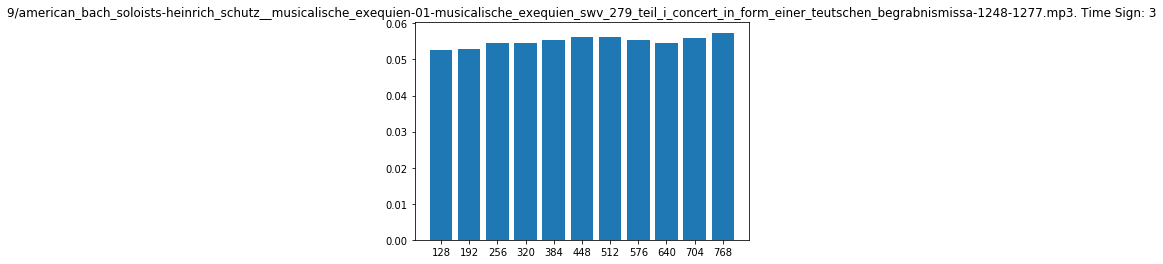

0
7
../mp3/5/new_york_consort_of_viols-dances_and_canzonas_of_holborne_and_brade-01-3_almaines_holborne-262-291.mp3
72.11538696289062 bpm,  16000.0 Hz
Frame Size: 416
FFT Size: 512
Padding length: 96
Found first note for frame with E1= 4.303638831970602e-07 , E2= 1.8326219708431069e-10 , and E1/E2= 2348.3505602580394
Spectrogram done. Size is (axis1, axis2): (2240, 257)
11.0
is estimation equal to truth? False


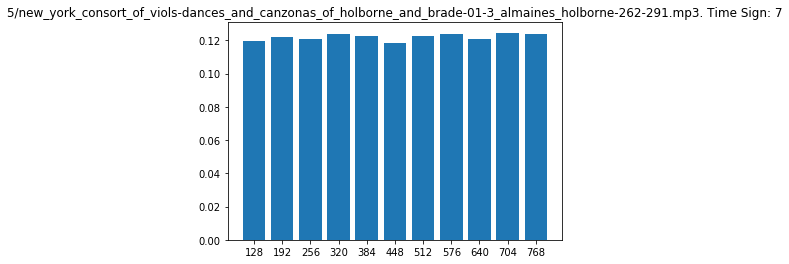

4
../mp3/f/pain_factor-8_seconds-01-8_seconds-59-88.mp3
145.63107299804688 bpm,  16000.0 Hz
Frame Size: 206
FFT Size: 256
Padding length: 50
Found first note for frame with E1= 2.2698513930663466e-06 , E2= 1.585500480905111e-10 , and E1/E2= 14316.308448992471
Spectrogram done. Size is (axis1, axis2): (4524, 129)
10.0
is estimation equal to truth? False


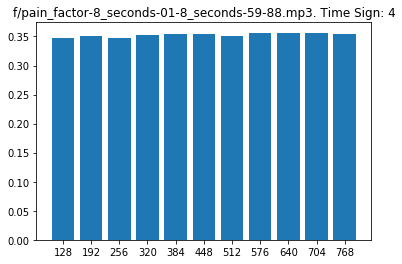

../mp3/f/pain_factor-8_seconds-01-8_seconds-175-204.mp3
145.63107299804688 bpm,  16000.0 Hz
Frame Size: 206
FFT Size: 256
Padding length: 50
Found first note for frame with E1= 0.4271763265132904 , E2= 0.0006445740582421422 , and E1/E2= 662.7265262245728
Spectrogram done. Size is (axis1, axis2): (4524, 129)
11.0
is estimation equal to truth? False


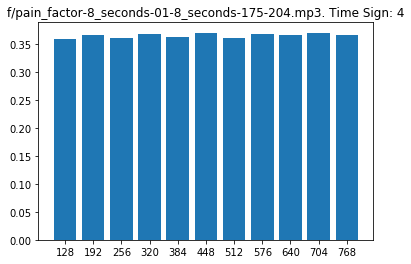

0
4
../mp3/4/justin_bianco-siren-01-another_century-30-59.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 2.3285181782739528e-07 , E2= 1.9755803937204774e-10 , and E1/E2= 1178.6501757535725
Spectrogram done. Size is (axis1, axis2): (3106, 257)
11.0
is estimation equal to truth? False


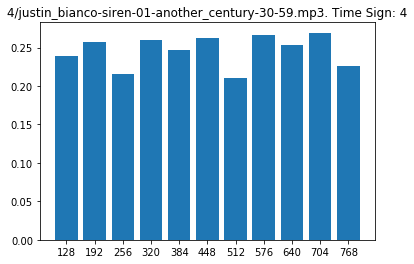

4
../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.0006346059963107109 , E2= 1.0131707313121296e-06 , and E1/E2= 626.356424142701
Spectrogram done. Size is (axis1, axis2): (3949, 129)
12.0
is estimation equal to truth? False


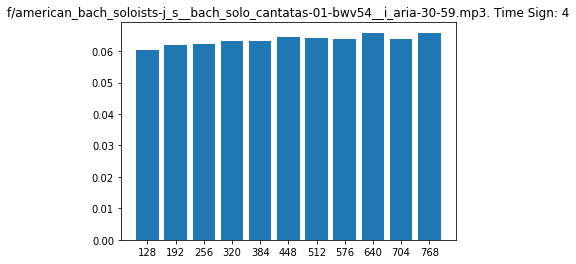

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 2.1485303136614675e-07 , E2= 1.8100462795267447e-10 , and E1/E2= 1187.0029722241263
Spectrogram done. Size is (axis1, axis2): (3949, 129)
11.0
is estimation equal to truth? False


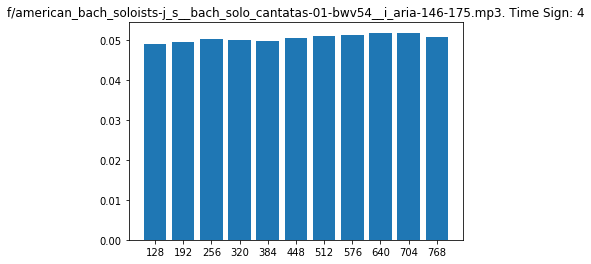

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-262-291.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.006790936924517155 , E2= 5.091570074000629e-06 , and E1/E2= 1333.760868615773
Spectrogram done. Size is (axis1, axis2): (3949, 129)
11.0
is estimation equal to truth? False


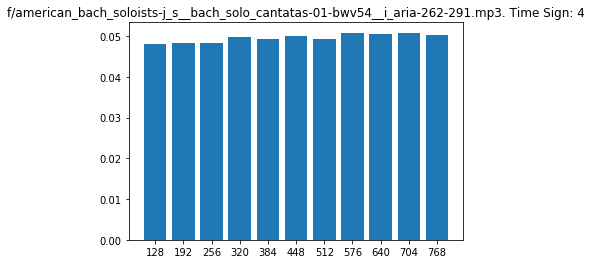

3
../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-30-59.mp3
107.14286041259766 bpm,  16000.0 Hz
Frame Size: 280
FFT Size: 512
Padding length: 232
Found first note for frame with E1= 0.0006900576991029084 , E2= 6.919563144691665e-09 , and E1/E2= 99725.61629591968
Spectrogram done. Size is (axis1, axis2): (3328, 257)
12.0
is estimation equal to truth? False


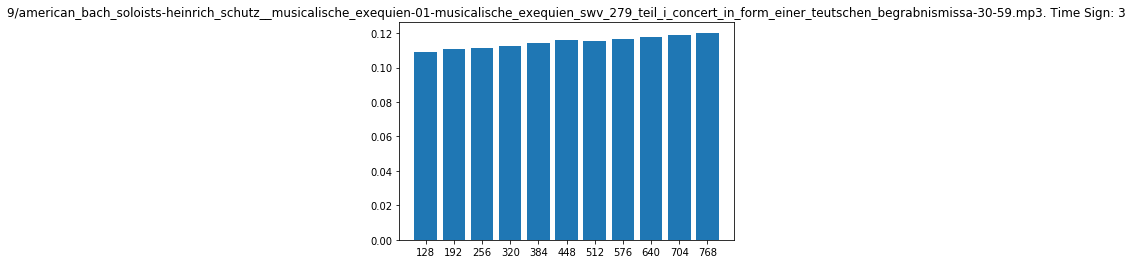

../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-407-436.mp3
65.78947448730469 bpm,  16000.0 Hz
Frame Size: 456
FFT Size: 512
Padding length: 56
Found first note for frame with E1= 1.3292846290369198e-07 , E2= 1.5740186931623157e-10 , and E1/E2= 844.516418268383
Spectrogram done. Size is (axis1, axis2): (2043, 257)
12.0
is estimation equal to truth? False


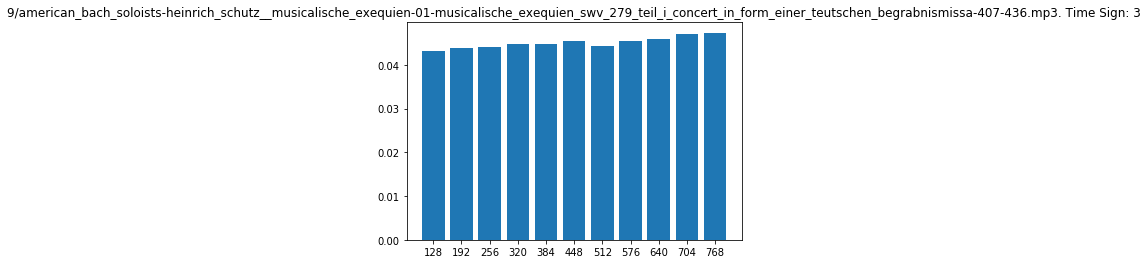

0
4
../mp3/e/burning_babylon-stereo_mash_up-01-7_nine_skank-175-204.mp3
141.50942993164062 bpm,  16000.0 Hz
Frame Size: 212
FFT Size: 256
Padding length: 44
Found first note for frame with E1= 0.0005537120159715414 , E2= 3.1459788107923714e-09 , and E1/E2= 176006.27635253494
Spectrogram done. Size is (axis1, axis2): (4396, 129)
11.0
is estimation equal to truth? False


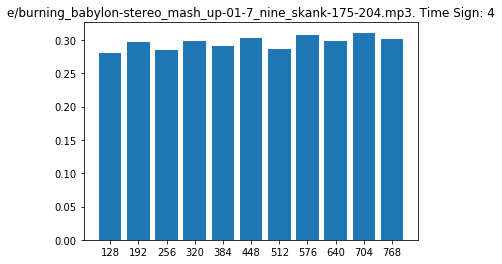

4
../mp3/4/justin_bianco-siren-01-another_century-117-146.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 1.7690793185920484e-07 , E2= 2.4593882486101393e-10 , and E1/E2= 719.3168136799054
Spectrogram done. Size is (axis1, axis2): (3106, 257)
11.0
is estimation equal to truth? False


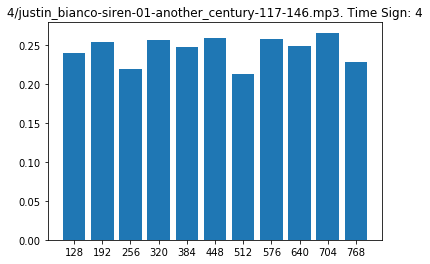

3
../mp3/e/steven_devine-portrait_of_an_english_harpsichord-01-lesson_1_in_g_major_prelude_james_nares-0-29.mp3
87.20930480957031 bpm,  16000.0 Hz
Frame Size: 344
FFT Size: 512
Padding length: 168
Found first note for frame with E1= 2.1923372628407378e-07 , E2= 3.255955227654539e-10 , and E1/E2= 673.3315139655684
Spectrogram done. Size is (axis1, axis2): (2709, 257)
11.0
is estimation equal to truth? False


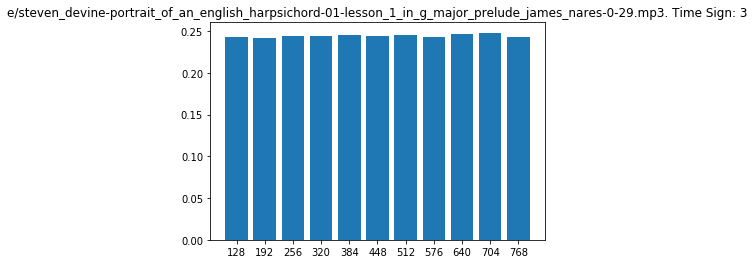

../mp3/8/jacob_heringman-josquin_des_prez_lute_settings-01-anon__praeter_rerum_seriem-262-291.mp3
76.53060913085938 bpm,  16000.0 Hz
Frame Size: 392
FFT Size: 512
Padding length: 120
Found first note for frame with E1= 2.7727148221856623e-07 , E2= 1.5314059742532748e-10 , and E1/E2= 1810.5681111356896
Spectrogram done. Size is (axis1, axis2): (2377, 257)
9.0
is estimation equal to truth? False


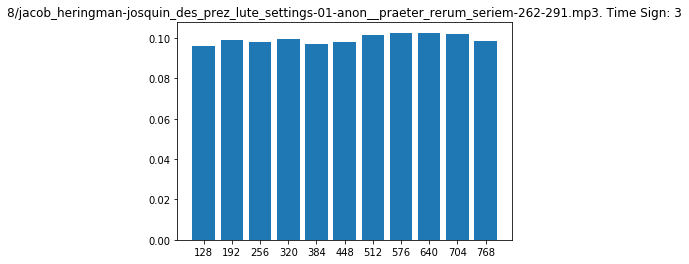

../mp3/c/jamie_janover-now_center_of_time-01-arc-291-320.mp3
78.9473648071289 bpm,  16000.0 Hz
Frame Size: 380
FFT Size: 512
Padding length: 132
Found first note for frame with E1= 7.10087874722376e-07 , E2= 1.8269566415263228e-10 , and E1/E2= 3886.725380242939
Spectrogram done. Size is (axis1, axis2): (2452, 257)
7.0
is estimation equal to truth? False


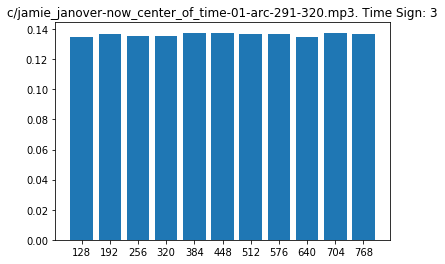

4
../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-146-175.mp3
94.93670654296875 bpm,  16000.0 Hz
Frame Size: 316
FFT Size: 512
Padding length: 196
Found first note for frame with E1= 0.2229491025209427 , E2= 0.0003804757434409112 , and E1/E2= 585.974549927037
Spectrogram done. Size is (axis1, axis2): (2949, 257)
10.0
is estimation equal to truth? False


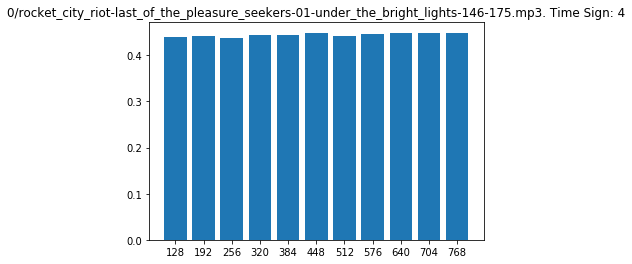

../mp3/6/mercy_machine-the_devil_i_know-01-30_years-262-291.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 1.6306650650221854e-05 , E2= 1.5560770449951633e-08 , and E1/E2= 1047.9333721083547
Spectrogram done. Size is (axis1, axis2): (3851, 129)
10.0
is estimation equal to truth? False


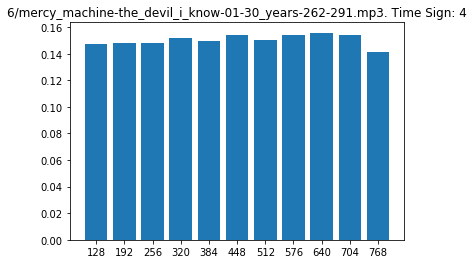

../mp3/f/pain_factor-8_seconds-01-8_seconds-175-204.mp3
145.63107299804688 bpm,  16000.0 Hz
Frame Size: 206
FFT Size: 256
Padding length: 50
Found first note for frame with E1= 0.4271763265132904 , E2= 0.0006445740582421422 , and E1/E2= 662.7265262245728
Spectrogram done. Size is (axis1, axis2): (4524, 129)
11.0
is estimation equal to truth? False


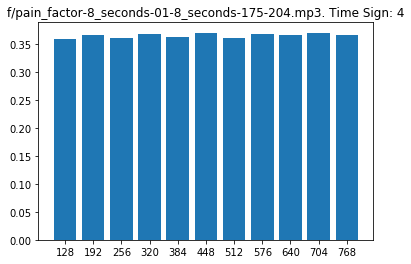

0
7
../mp3/c/mountain_mirrors-lunar_ecstasy-01-a_short_burst_of_clarity-146-175.mp3
85.2272720336914 bpm,  16000.0 Hz
Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 1.7599653574507101e-06 , E2= 1.984805375609966e-10 , and E1/E2= 8867.193625520293
Spectrogram done. Size is (axis1, axis2): (2647, 257)
11.0
is estimation equal to truth? False


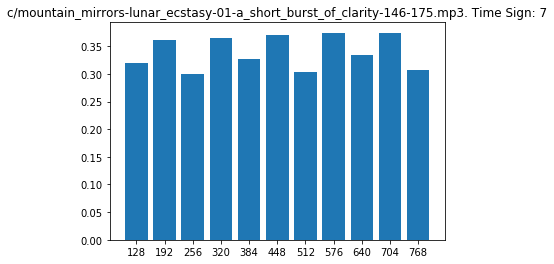

4
../mp3/c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.09705301374197006 , E2= 1.695222636044491e-05 , and E1/E2= 5725.089535639194
Spectrogram done. Size is (axis1, axis2): (2560, 257)
11.0
is estimation equal to truth? False


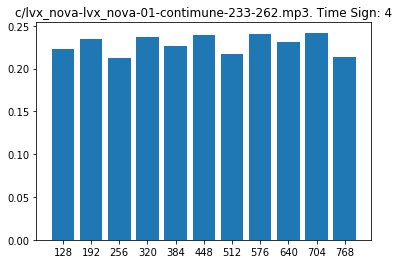

../mp3/c/lvx_nova-lvx_nova-01-contimune-291-320.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.04663815349340439 , E2= 8.684227395860944e-06 , and E1/E2= 5370.44360625943
Spectrogram done. Size is (axis1, axis2): (2560, 257)
11.0
is estimation equal to truth? False


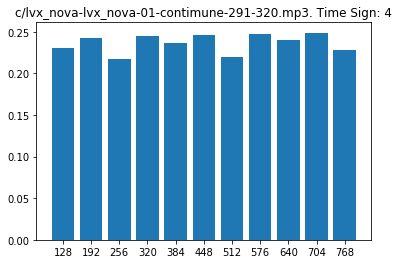

../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-88-117.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 0.0015554045094177127 , E2= 2.804879954965145e-07 , and E1/E2= 5545.351438889088
Spectrogram done. Size is (axis1, axis2): (3851, 129)
11.0
is estimation equal to truth? False


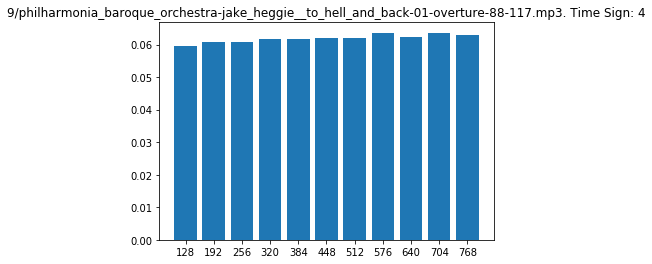

0
3
../mp3/1/tim_rayborn-ashek-01-ashek-436-465.mp3
81.52173614501953 bpm,  16000.0 Hz
Frame Size: 368
FFT Size: 512
Padding length: 144
Found first note for frame with E1= 0.01631634309887886 , E2= 2.324885099369567e-05 , and E1/E2= 701.8128811313437
Spectrogram done. Size is (axis1, axis2): (2532, 257)
10.0
is estimation equal to truth? False


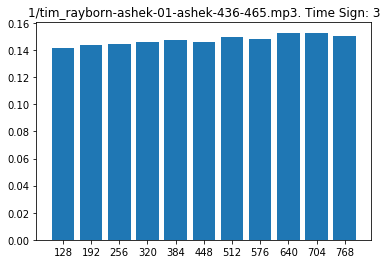

4
../mp3/f/the_headroom_project-jetuton_andawai-01-linda_morena-59-88.mp3
85.2272720336914 bpm,  16000.0 Hz
Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 0.02449682727456093 , E2= 4.659142723539844e-05 , and E1/E2= 525.7797137398948
Spectrogram done. Size is (axis1, axis2): (2647, 257)
10.0
is estimation equal to truth? False


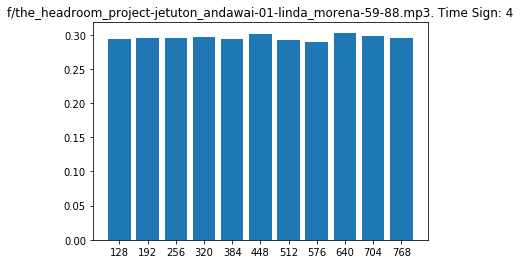

4
../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-59-88.mp3
118.11023712158203 bpm,  16000.0 Hz
Frame Size: 254
FFT Size: 256
Padding length: 2
Found first note for frame with E1= 8.583756994084979e-08 , E2= 1.264948423784773e-10 , and E1/E2= 678.5855322387024
Spectrogram done. Size is (axis1, axis2): (3669, 129)
11.0
is estimation equal to truth? False


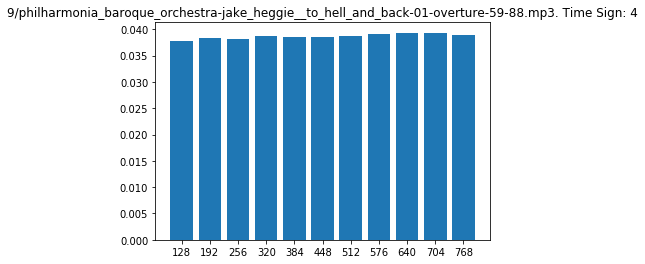

../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-88-117.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 0.0015554045094177127 , E2= 2.804879954965145e-07 , and E1/E2= 5545.351438889088
Spectrogram done. Size is (axis1, axis2): (3851, 129)
11.0
is estimation equal to truth? False


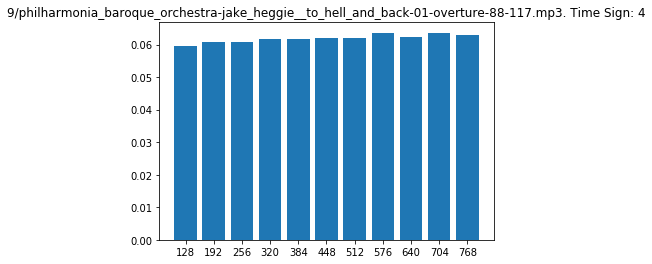

3
../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-117-146.mp3
109.48905181884766 bpm,  16000.0 Hz
Frame Size: 274
FFT Size: 512
Padding length: 238
Found first note for frame with E1= 7.105493864401069e-07 , E2= 4.2368186736752023e-10 , and E1/E2= 1677.0823610058942
Spectrogram done. Size is (axis1, axis2): (3401, 257)
10.0
is estimation equal to truth? False


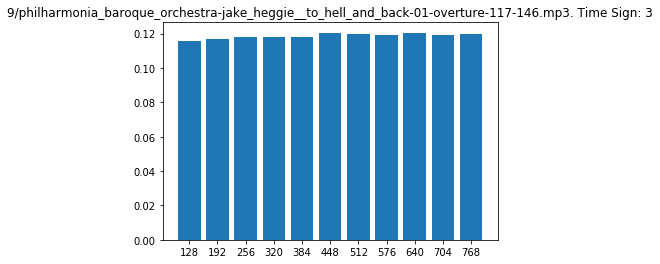

4
../mp3/6/mercy_machine-the_devil_i_know-01-30_years-262-291.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 1.6306650650221854e-05 , E2= 1.5560770449951633e-08 , and E1/E2= 1047.9333721083547
Spectrogram done. Size is (axis1, axis2): (3851, 129)
10.0
is estimation equal to truth? False


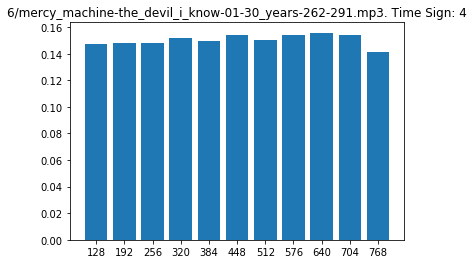

../mp3/4/justin_bianco-siren-01-another_century-175-204.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 0.011281756684184074 , E2= 9.002353181131184e-06 , and E1/E2= 1253.2008528426202
Spectrogram done. Size is (axis1, axis2): (3106, 257)
11.0
is estimation equal to truth? False


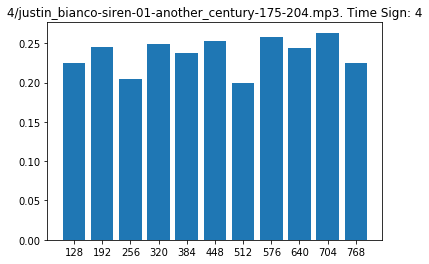

3
../mp3/c/jamie_janover-now_center_of_time-01-arc-291-320.mp3
78.9473648071289 bpm,  16000.0 Hz
Frame Size: 380
FFT Size: 512
Padding length: 132
Found first note for frame with E1= 7.10087874722376e-07 , E2= 1.8269566415263228e-10 , and E1/E2= 3886.725380242939
Spectrogram done. Size is (axis1, axis2): (2452, 257)
7.0
is estimation equal to truth? False


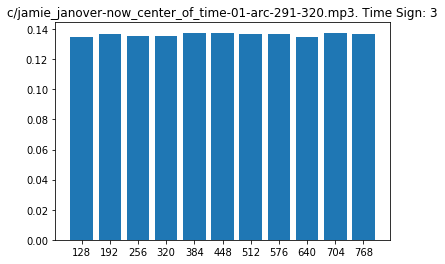

../mp3/c/jamie_janover-now_center_of_time-01-arc-436-465.mp3
156.25 bpm,  16000.0 Hz
Frame Size: 192
FFT Size: 256
Padding length: 64
Found first note for frame with E1= 2.916356152127264e-07 , E2= 1.72334868597801e-10 , and E1/E2= 1692.2612213396708
Spectrogram done. Size is (axis1, axis2): (4853, 129)
9.0
is estimation equal to truth? False


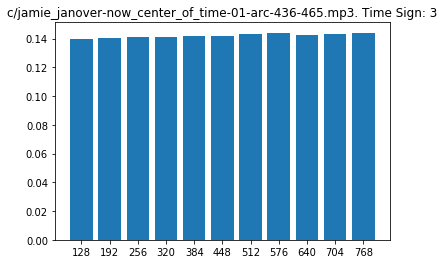

0
0
4
../mp3/1/ambient_teknology-phoenix-01-ambient_teknology-0-29.mp3
70.09346008300781 bpm,  16000.0 Hz
Frame Size: 428
FFT Size: 512
Padding length: 84
Found first note for frame with E1= 0.6818920969963074 , E2= 0.0011740741319954395 , and E1/E2= 580.7913473379857
Spectrogram done. Size is (axis1, axis2): (2177, 257)
11.0
is estimation equal to truth? False


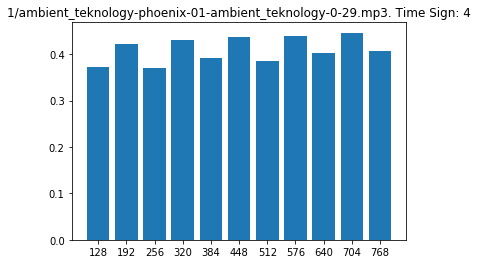

../mp3/1/ambient_teknology-phoenix-01-ambient_teknology-146-175.mp3
70.09346008300781 bpm,  16000.0 Hz
Frame Size: 428
FFT Size: 512
Padding length: 84
Found first note for frame with E1= 1.9717947452591034e-07 , E2= 1.775786045987715e-10 , and E1/E2= 1110.3785558593945
Spectrogram done. Size is (axis1, axis2): (2177, 257)
11.0
is estimation equal to truth? False


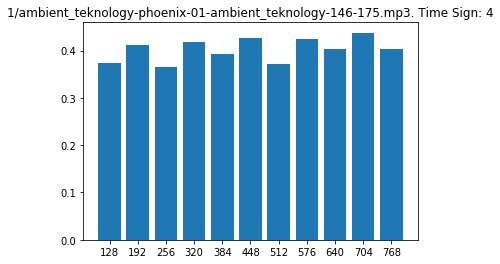

../mp3/1/ambient_teknology-phoenix-01-ambient_teknology-407-436.mp3
70.09346008300781 bpm,  16000.0 Hz
Frame Size: 428
FFT Size: 512
Padding length: 84
Found first note for frame with E1= 9.472198030380241e-07 , E2= 1.3150222577529291e-10 , and E1/E2= 7203.070499024139
Spectrogram done. Size is (axis1, axis2): (2177, 257)
11.0
is estimation equal to truth? False


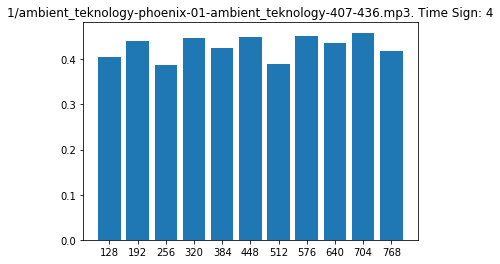

4
../mp3/c/lvx_nova-lvx_nova-01-contimune-30-59.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.017826903611421585 , E2= 3.817473043454811e-06 , and E1/E2= 4669.817811021986
Spectrogram done. Size is (axis1, axis2): (2560, 257)
11.0
is estimation equal to truth? False


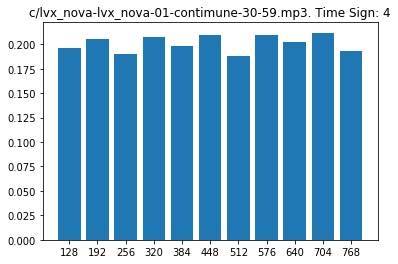

../mp3/0/williamson-a_few_things_to_hear_before_we_all_blow_up-01-2_percent_er-117-146.mp3
79.7872314453125 bpm,  16000.0 Hz
Frame Size: 376
FFT Size: 512
Padding length: 136
Found first note for frame with E1= 0.22494326531887054 , E2= 0.0003733573539648205 , and E1/E2= 602.4878388763859
Spectrogram done. Size is (axis1, axis2): (2478, 257)
11.0
is estimation equal to truth? False


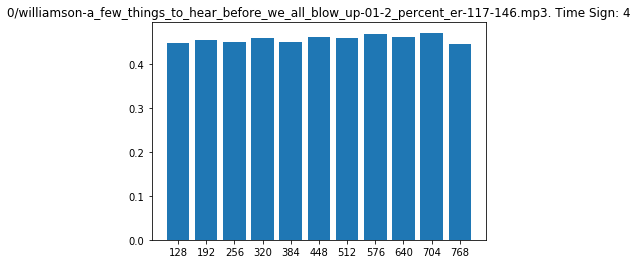

../mp3/a/liquid_zen-magic_midsummer-01-4_oclock_sunny_and_hot-30-59.mp3
128.2051239013672 bpm,  16000.0 Hz
Frame Size: 234
FFT Size: 256
Padding length: 22
Found first note for frame with E1= 2.203955205004604e-07 , E2= 1.2499185020331538e-10 , and E1/E2= 1763.2791269347454
Spectrogram done. Size is (axis1, axis2): (3982, 129)
11.0
is estimation equal to truth? False


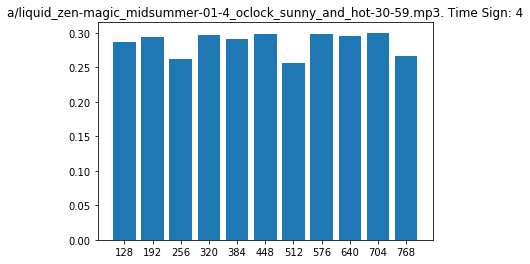

3
../mp3/e/burning_babylon-stereo_mash_up-01-7_nine_skank-146-175.mp3
70.75471496582031 bpm,  16000.0 Hz
Frame Size: 424
FFT Size: 512
Padding length: 88
Found first note for frame with E1= 1.6168545471373363e-06 , E2= 2.1710001851804606e-10 , and E1/E2= 7447.509945757734
Spectrogram done. Size is (axis1, axis2): (2198, 257)
11.0
is estimation equal to truth? False


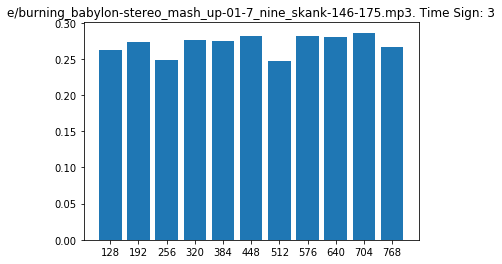

4
../mp3/4/justin_bianco-siren-01-another_century-30-59.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 2.3285181782739528e-07 , E2= 1.9755803937204774e-10 , and E1/E2= 1178.6501757535725
Spectrogram done. Size is (axis1, axis2): (3106, 257)
11.0
is estimation equal to truth? False


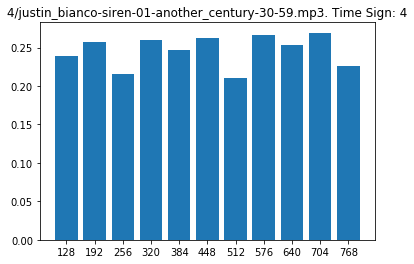

In [75]:
tags = ['rock', 'classical', 'heavy', 'jazz', 'opera','funk', 'funky', 'electronica', 'guitar', 'folk', 'fast', 'irish',
       'arabic', 'instrumental', 'spanish', 'orchestra', 'piano', 'celtic', 'woman', 'dance', 'techno', 'hip hop']
results_dict = {"tag": [], "song":[], "original_ts":[], "conf_original_ts":[], "estimated_ts":[],
                "conf_estimated_ts":[], "equal":[]}

for tag in tags:
    for timeSig, paths in getTrackCollection(tag, 3, 0.8).items():
        print(timeSig)
        if int(timeSig) == 0:
            continue
        for path in paths:
            full_path = path_to_data_set + path['path']
            print(full_path)
            audioInput, bpm, fs = get_audio_and_tempo(full_path)
            spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(path)
            SM = compute_similarity()

            top_candidate = list(SM.keys())[list(SM.values()).index(max(list(SM.values())))] / 64
            print(top_candidate)
            confidence = max(list(SM.values())) / sum(list(SM.values()))

            print("is estimation equal to truth? " + str(timeSig == int(top_candidate)))

            ordered_SM = OrderedDict(sorted(SM.items()))
            plt.bar(range(len(ordered_SM)), list(ordered_SM.values()), align='center')
            xlabels = list(ordered_SM.keys())
            plt.title(path['path'] + ". Time Sign: " + timeSig)
            plt.xticks(range(len(ordered_SM)), xlabels)
            plt.show()

            results_dict["tag"].append(tag)
            results_dict["song"].append(path['path'])
            results_dict["original_ts"].append(timeSig)
            results_dict["conf_original_ts"].append(path['timeSignatureConfidence'])
            results_dict["estimated_ts"].append(int(top_candidate))
            results_dict["conf_estimated_ts"].append(confidence)
            results_dict["equal"].append(timeSig == int(top_candidate))

            

In [64]:
results
df_results = pd.DataFrame(results_dict)
print(df_results)

          tag                                               song original_ts  \
0        rock       c/lvx_nova-lvx_nova-01-contimune-233-262.mp3           4   
1        rock  0/rocket_city_riot-last_of_the_pleasure_seeker...           4   
2        rock  0/rocket_city_riot-last_of_the_pleasure_seeker...           4   
3        rock  c/mountain_mirrors-lunar_ecstasy-01-a_short_bu...           7   
4   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
5   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
6   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
7   classical  0/american_bach_soloists-j_s__bach__cantatas_v...           3   
8   classical  9/american_bach_soloists-heinrich_schutz__musi...           3   
9   classical  9/american_bach_soloists-heinrich_schutz__musi...           3   
10  classical  5/new_york_consort_of_viols-dances_and_canzona...           7   
11      heavy     f/pain_factor-8_second

In [77]:
top_candidate = list(SM.keys())[list(SM.values()).index(max(list(SM.values())))] / 64
if top_candidate == 2:
    time_signature = '{}/2'.format(int(top_candidate))
elif top_candidate > 2 and top_candidate < 6:
    time_signature = '{}/4'.format(int(top_candidate))
else:
    time_signature = '{}/8'.format(int(top_candidate))
print('The estimated time signature is... ', time_signature)

The estimated time signature is...  11/8
